In [1]:
import pprint  # Import pprint module for pretty printing
import requests  # Import requests module for making HTTP requests
import os  # Operating system dependent functionality
import pickle  # Import pickle module for serializing and deserializing Python objects
import numpy as np  # Import numpy for numerical operations
import pandas as pd  # Import pandas for data manipulation and analysis
import firebase_admin
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.ensemble import RandomForestClassifier  # Import RandomForest classifier
from sklearn.model_selection import train_test_split  # Import train_test_split function for splitting data
from firebase_admin import credentials, initialize_app, db
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay  # Import functions and classes for model evaluation


In [2]:
def ph2label(ph):
    if ph <= 5:
        return 0
    elif ph <= 8:
        return 1
    else:
        return 2


def generate_dataset(
                    n_samples=10000,
                    data_path='dataset.csv'
                    ):
    """
    Generate a synthetic dataset of water quality measurements.

    Args:
    n_samples (int): Number of samples to generate. Default is 5000.
    data_path (str): Path to save/load the generated dataset. Default is 'dataset.csv'.

    Returns:
    tuple: A tuple containing the feature matrix X and target vector Y.
    """
    # Define the ranges for each feature
    ranges = [
        (0, 14),                 # pH range
        (0, 100),                # Turbidity range
        (0, 1000),               # TDS range
        (15, 80),                # Water temperature range
        (15, 100),               # Humidity range
        (15, 80)                 # Temperature range
    ]
    
    # Define column names
    columns = [
        'ph',
        'turbidity',
        'tds',
        'water_temperature',
        'humidity',
        'temperature'
    ]

    # Check if the dataset file exists, if not generate it
    if not os.path.exists(data_path):
        # Create an empty DataFrame with specified columns
        dataset = pd.DataFrame(columns=columns)
        
        # Generate n_samples random samples within defined ranges
        for i in range(n_samples):
            row = [np.random.uniform(r[0], r[1]) for r in ranges]
            dataset.loc[i] = row
        
        # Assign quality label based on pH value
        dataset['quality'] = dataset['ph'].apply(lambda x: ph2label(x))
        
        # Save the generated dataset to a CSV file
        dataset.to_csv(data_path, index=False)

    # Read the dataset from the CSV file
    data = pd.read_csv(data_path)
    
    # Extract feature matrix X and target vector Y
    Y = data['quality'].values  
    X = data.drop('quality', axis=1).values

    return X, Y


In [3]:
# Generate synthetic dataset of water quality measurements
X, Y = generate_dataset()

# Split the dataset into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

# Print shapes of the training and testing data arrays
print("Xtrain shape: ", Xtrain.shape)  # Print shape of training input data
print("Ytrain shape: ", Ytrain.shape)  # Print shape of training target data
print("Xtest shape: ", Xtest.shape)    # Print shape of testing input data
print("Ytest shape: ", Ytest.shape)    # Print shape of testing target data


Xtrain shape:  (8000, 6)
Ytrain shape:  (8000,)
Xtest shape:  (2000, 6)
Ytest shape:  (2000,)


In [4]:
# Initialize and train a RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(Xtrain, Ytrain)

# Initialize and train an XGBClassifier
xgb = XGBClassifier()
xgb.fit(Xtrain, Ytrain)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [5]:
# Predict using the trained Random Forest Classifier
Prfc = rfc.predict(Xtest)

# Predict using the trained XGBoost Classifier
Pxgb = xgb.predict(Xtest)

# Compute confusion matrices for both classifiers
cm_rfc = confusion_matrix(Ytest, Prfc)
cm_xgb = confusion_matrix(Ytest, Pxgb)

# Print classification reports for both classifiers
print("================== Random Forest Classifier ==========")
print(classification_report(Ytest, Prfc))
print("================== XGBoost Classifier ================")
print(classification_report(Ytest, Pxgb))


================== Random Forest Classifier ==========
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      1.00      1.00       412
           2       1.00      1.00      1.00       861

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

================== XGBoost Classifier ================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      1.00      1.00       412
           2       1.00      1.00      1.00       861

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



========== Confusion Matrix - RFC ================
========== Confusion Matrix - XGB ================


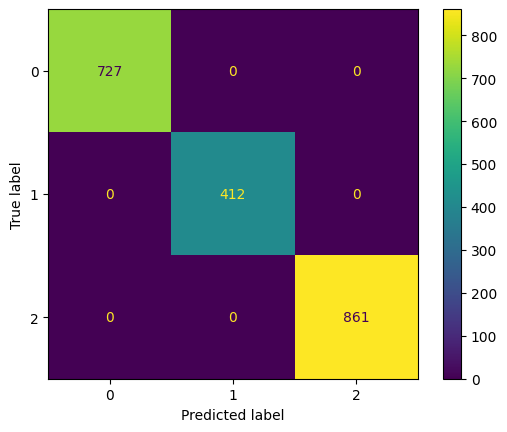

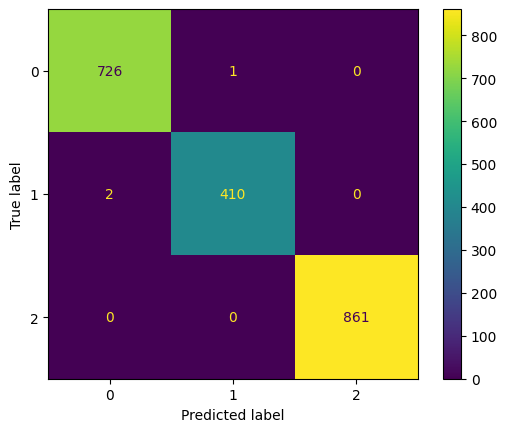

In [6]:
# Print title for Random Forest Classifier confusion matrix
print("========== Confusion Matrix - RFC ================")
# Create ConfusionMatrixDisplay object for Random Forest Classifier
disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)
# Plot the confusion matrix for Random Forest Classifier
disp_rfc.plot()

# Print title for XGBoost Classifier confusion matrix
print("========== Confusion Matrix - XGB ================")
# Create ConfusionMatrixDisplay object for XGBoost Classifier
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
# Plot the confusion matrix for XGBoost Classifier
disp_xgb.plot()

In [7]:
# save xgboost model
pickle.dump(xgb, open("xgboost_model.pkl", "wb"))

## Inference

In [8]:
import pprint  # Import pprint module for pretty printing
import os      # Operating system dependent functionality
import pickle  # Import pickle module for serializing and deserializing Python objects
import datetime
import numpy as np  # Import numpy for numerical operations
import pandas as pd  # Import pandas for data manipulation and analysis

In [9]:
# Load the XGBoost model from the pickle file "xgboost_model.pkl"
with open("xgboost_model.pkl", "rb") as f:
    model = pickle.load(f)

In [19]:
# Sample data dictionary containing water quality measurements
sample_data = {
            'ph': 6.1,                   # pH measurement
            'turbidity': 40,             # Turbidity measurement
            'tds': 500,                  # Total Dissolved Solids (TDS) measurement
            'water_temperature':32,     # Water temperature measurement
            'humidity': 20,              # Humidity measurement
            'temperature': 32            # Temperature measurement
            }

In [20]:
def inference_water_quality(data):
    """
    Perform inference to predict water quality label based on input data.

    Args:
    data (dict): A dictionary containing water quality measurements.

    Returns:
    str: Predicted water quality label ("Good" or "Bad").
    """
    # Convert input data into DataFrame
    df_ = pd.DataFrame(data, index=[0])
    
    # Reshape data for model prediction
    x = df_.values
    x = x.reshape(1, -1)
    
    # Perform prediction using the model and extract probability
    p = model.predict(x).squeeze()
    
    # Determine label based on predicted probability
    if p == 0:
        label = "Bad"
    elif p == 1:
        label = "Normal"
    else:
        label = "Good"
    
    return label


In [21]:
inference_water_quality(sample_data)

'Normal'